In [1]:
import pandas as pd
import geopandas as gpd

## PostGIS

### PostGIS에서 데이터 가져오기

In [2]:
# PostGIS 접속 정보 
f = open('../../etc/postgis.txt', 'r')
lines = f.readlines()

database = lines[0].replace("\n", "")
user = lines[1].replace("\n", "")
host = lines[2].replace("\n", "")
port = lines[3].replace("\n", "")
password = lines[4].replace("\n", "")

In [5]:
#psycopg2를 이용하여 PostgreSQL에 연결
import psycopg2 as psql  #PostgreSQL 연동 어댑터/드라이버 
#con = psql.connect(database=database, user=user, host=host,port=port,password=password)

In [4]:
#테이블 목록 조회 
cursor = con.cursor()
cursor.execute("select relname from pg_class where relkind='r' and relname !~ '^(pg_|sql_)';")
print(cursor.fetchall())

[('spatial_ref_sys',), ('bldg',)]


In [5]:
from sqlalchemy import create_engine
engine = create_engine("postgresql://" + user + ":" + password + "@" + host + ":" + port + "/" + database)  

In [177]:
# 예전 레퍼런스
# query = 'SELECT * FROM bldg;'
# gdf = gpd.GeoDataFrame.from_postgis(query, con)

In [6]:
# 현재 geopandas 레퍼런스 
sql = "SELECT * FROM bldg"
gdf = gpd.read_postgis(sql, engine)

In [7]:
gdf.info()
gdf.head()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 21637 entries, 0 to 21636
Data columns (total 34 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   id_0        21637 non-null  int64   
 1   geom        21637 non-null  geometry
 2   id          21637 non-null  int64   
 3   bdtyp_cd    21637 non-null  object  
 4   bd_mgt_sn   21637 non-null  object  
 5   bsi_int_sn  21637 non-null  float64 
 6   bsi_zon_no  21637 non-null  object  
 7   buld_mnnm   21637 non-null  int64   
 8   buld_nm     4952 non-null   object  
 9   buld_nm_dc  5075 non-null   object  
 10  buld_se_cd  21637 non-null  object  
 11  buld_slno   21637 non-null  int64   
 12  bul_dpn_se  21637 non-null  object  
 13  bul_eng_nm  3596 non-null   object  
 14  bul_man_no  21637 non-null  int64   
 15  emd_cd      21637 non-null  object  
 16  eqb_man_sn  21637 non-null  float64 
 17  gro_flo_co  21637 non-null  int64   
 18  li_cd       21637 non-null  object  
 

id_0                                               geom    id bdtyp_cd  \
0     1  MULTIPOLYGON (((126.94371 37.36034, 126.94364 ...  1684    01003   
1     2  MULTIPOLYGON (((126.95513 37.40435, 126.95514 ...  1868    02003   
2     3  MULTIPOLYGON (((126.98819 37.35845, 126.98819 ...  2257    02003   
3     4  MULTIPOLYGON (((126.91218 37.39951, 126.91236 ...  2289    02003   
4     5  MULTIPOLYGON (((126.90566 37.40147, 126.90561 ...  2290    02003   

                   bd_mgt_sn  bsi_int_sn bsi_zon_no  buld_mnnm buld_nm  \
0  4141010500107480006005755      8400.0      15833         32    None   
1  4117310200113870007000899     23464.0      13936         37    None   
2  4143010500105420000000001      5911.0      16065         13    None   
3  4117110100109080115013020      9073.0      14010         11    None   
4  4117110300101390021020567     12211.0      14017         13    None   

  buld_nm_dc  ... mvm_res_cd   ntfc_de        opert_de pos_bul_nm  rds_man_no  \
0       None  ...         71  20161110  20170102144633       None       274.0   
1       None  ...         71  20190501  20190514140208       그랜드지      1009.0   
2       None  ...         71  20190110  20190114143645       None       181.0   
3       None  ...         31  20150610  20150611093457       나은캐슬       218.0   
4       None  ...         71  20150610  20160822093204       None       360.0   

  rds_sig_cd    rn_cd  sig_cd und_flo_co     ar_geom  
0      41410  3200006   41410          0   69.979271  
1      41173  4349085   41173          0  173.209078  
2      41430  4403148   41430          0  138.712905  
3      41171  4346257   41171          0  157.025037  
4      41171  3182010   41171          0  163.297830  

[5 rows x 34 columns]

In [10]:
# 10% 샘플링
gdf2 = gdf.sample(frac=0.1)

In [13]:
len(gdf2)

2164

In [14]:
import folium

In [15]:
# Initialize the map:
attr = ('&copy; <a href="http://xdworld.vworld.kr">브이월드</a> ')
tiles = "http://xdworld.vworld.kr:8080/2d/gray/service/{z}/{x}/{y}.png"   #gray / midnight

In [16]:
gdf2.to_file("./data/gdf_bldg_sample.geojson",driver='GeoJSON', encoding='utf-8')

In [17]:
import json

with open('./data/gdf_bldg_sample.geojson', encoding='utf-8') as f:
    gjson_bldg = json.load(f)

In [18]:
m = folium.Map(location=[37.39, 126.94], tiles=tiles, attr=attr, zoom_start=13)

# Polygon GeoJson     
folium.GeoJson(gjson_bldg, name="geojson").add_to(m)    
    
m

### PostGIS에 공간 데이터 저장

In [173]:
# PostGIS에 공간데이터프레임 저장 
gdf2.to_postgis("bldg2", engine)  

멀티폴리곤을 폴리곤으로 변환  
https://gist.github.com/mhweber/cf36bb4e09df9deee5eb54dc6be74d26 

In [162]:
import geopandas as gpd
from shapely.geometry.polygon import Polygon
from shapely.geometry.multipolygon import MultiPolygon

def explode(gdf_in):
    gs = gdf_in.explode()
    gdf2222 = gs.reset_index().rename(columns={0: 'geometry'})
    gdf_out = gdf2222.merge(gdf.drop('geom', axis=1), left_on='level_0', right_index=True)
    gdf_out = gdf_out.set_index(['level_0', 'level_1']).set_geometry('geom')
    gdf_out.crs = gdf.crs
    return gdf_out

In [163]:
gdf2s = explode(gdf2)

In [164]:
gdf2s.head()

id_0_x    id_x bdtyp_cd_x                bd_mgt_sn_x  \
level_0 level_1                                                         
18736   0         18733  385355      02001  4143010500101000000004292   
9310    0          9309  124642      01001  4117110100106950229005438   
13629   0         13627  131142      01001  4117310200114180017000219   
10582   0         10580  127222      02003  4117310200114370003000248   
15951   0         15951  379849      01000  4143010700106800001002898   

                 bsi_int_sn_x bsi_zon_no_x  buld_mnnm_x buld_nm_x  \
level_0 level_1                                                     
18736   0              6464.0        16049           43      None   
9310    0             14379.0        14006           79      None   
13629   0             26458.0        13938           74      None   
10582   0             23672.0        13939           13      None   
15951   0              4275.0        16032           36      None   

                buld_nm_dc_x buld_se_cd_x  ...  mvm_res_cd_y ntfc_de_y  \
level_0 level_1                            ...                           
18736   0               107동            0  ...            71  20110729   
9310    0               None            0  ...            79  20110729   
13629   0               None            0  ...            79  20110729   
10582   0                 A동            0  ...            71  20110729   
15951   0               None            0  ...            71  20110729   

                     opert_de_y  pos_bul_nm_y rds_man_no_y  rds_sig_cd_y  \
level_0 level_1                                                            
18736   0        20130306132431      모락산현대아파트        247.0         41430   
9310    0        20160121000000          None        630.0         41171   
13629   0        20160121000000          None       1148.0         41173   
10582   0        20120713103616          만안주택       1016.0         41173   
15951   0              20080324          None        126.0         41430   

                 rn_cd_y sig_cd_y  und_flo_co_y   ar_geom_y  
level_0 level_1                                              
18736   0        3201028    41430             0  393.731408  
9310    0        4346260    41171             0   89.898993  
13629   0        4349060    41173             0  160.650679  
10582   0        4349186    41173             1  118.855360  
15951   0        4403023    41430             1  134.101110  

[5 rows x 67 columns]

# Raster

https://aws.amazon.com/ko/blogs/korea/earth-on-aws-a-home-for-geospatial-data-on-aws/
https://registry.opendata.aws/landsat-8/  

http://www.acgeospatial.co.uk/cog-part-2-python/    
https://github.com/acgeospatial/Satellite_Imagery_Python/blob/master/cloud_native/COG_and_Landsat.ipynb

https://earthexplorer.usgs.gov/

Landsat 영상 설명  
https://remotepixel.ca/blog/searchapi_20171211.html

landsat scene id 조회 및 다운로드 사이트  
https://viewer.remotepixel.ca/?#8/37.47/126.62

In [2]:
%matplotlib inline
import rasterio
import matplotlib.pyplot as plt
import numpy as np
from rasterio.plot import show
import geopandas as gpd
from rasterio.mask import mask

In [3]:
landsatband = []
landsat_fp = 'http://landsat-pds.s3.amazonaws.com/c1/L8/116/034/LC08_L1TP_116034_20201224_20201224_01_RT/LC08_L1TP_116034_20201224_20201224_01_RT_'
bands=('4.TIF', '3.TIF', '2.TIF')
for i in range(1,11): ## 11 bands of Landsat right?
    band = landsat_fp+'B'+str(i)+'.TIF'
    if band.endswith((bands)):
        landsatband.append(band)
landsatband.sort(reverse=True)    ## because I want the order 4,3,2 (but change if you need to!)
print(landsatband)

['http://landsat-pds.s3.amazonaws.com/c1/L8/116/034/LC08_L1TP_116034_20201224_20201224_01_RT/LC08_L1TP_116034_20201224_20201224_01_RT_B4.TIF', 'http://landsat-pds.s3.amazonaws.com/c1/L8/116/034/LC08_L1TP_116034_20201224_20201224_01_RT/LC08_L1TP_116034_20201224_20201224_01_RT_B3.TIF', 'http://landsat-pds.s3.amazonaws.com/c1/L8/116/034/LC08_L1TP_116034_20201224_20201224_01_RT/LC08_L1TP_116034_20201224_20201224_01_RT_B2.TIF']


In [4]:
#import geopandas as gpd
df = gpd.read_file('./data/gdf_gu_sl2.geojson')
gdf = df.to_crs('epsg:32652')  #https://epsg.io/32652  - UTM 52N

<AxesSubplot:>

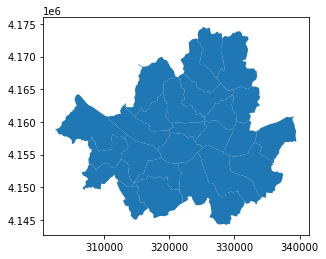

In [5]:
gdf.plot()

In [6]:
def read_imagery(path):
    data = rasterio.open(path)
    masked, mask_transform = mask(dataset=data, shapes=gdf.geometry, crop=False)
    print(masked.shape)
    return data, masked[0,:,:], mask_transform

In [7]:
lsarray=[]
for path in landsatband:
    data, masked, mask_transform = read_imagery(path)
    lsarray.append(masked)
rgb = np.stack(lsarray)

(1, 7961, 7841)
(1, 7961, 7841)
(1, 7961, 7841)


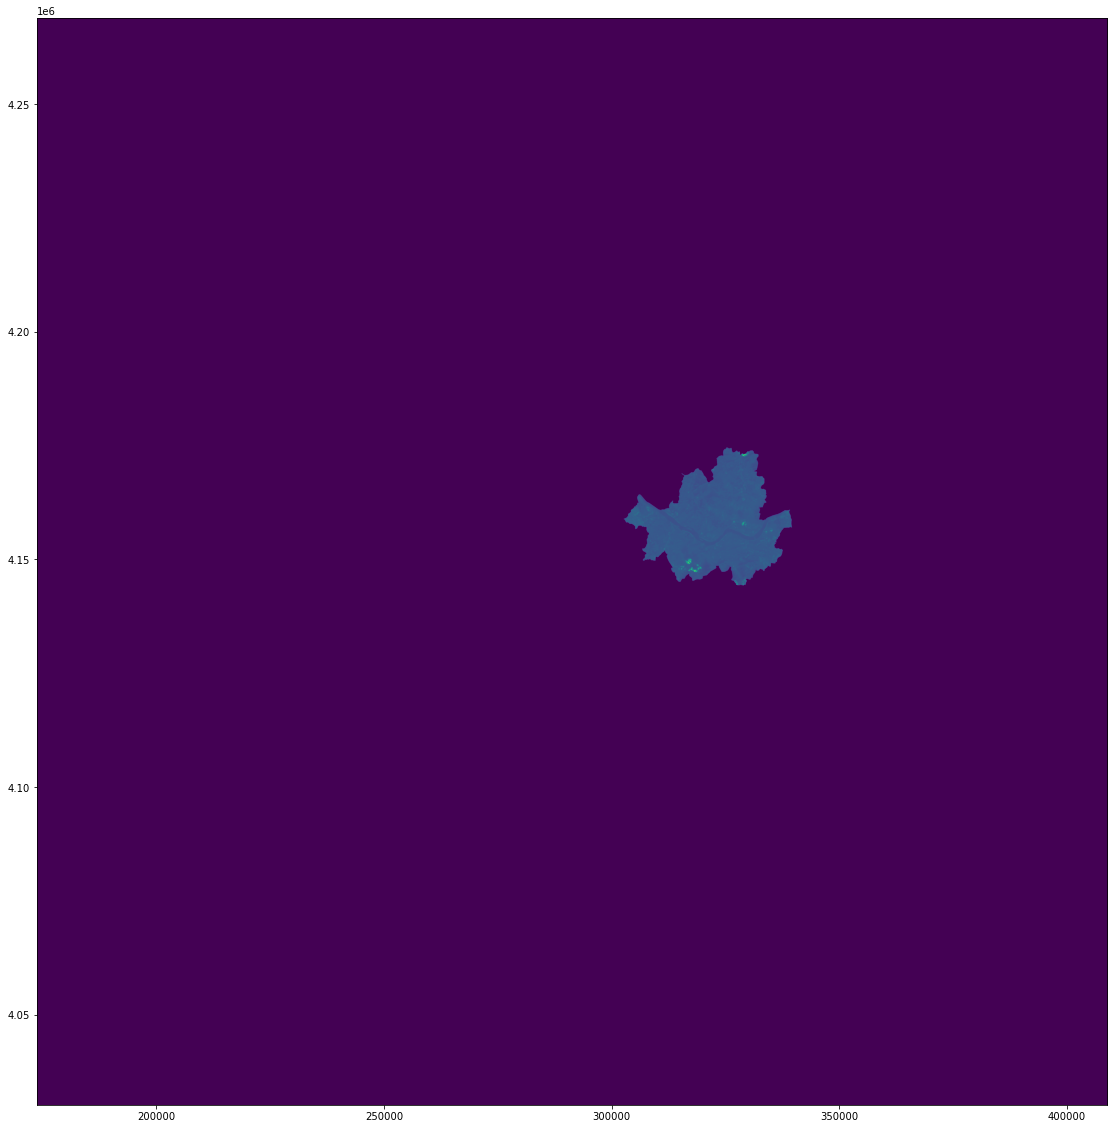

<AxesSubplot:>

In [8]:
plt.figure(figsize=(20, 20))
show(rgb[0], transform=mask_transform)

In [9]:
profile = data.meta
print(profile)
WIDTH = rgb.shape[2] ## get the dimensions of the image we are writting out
HEIGHT = rgb.shape[1]
profile.update(count = 3, transform=mask_transform, height = HEIGHT, width = WIDTH)
print(profile)

with rasterio.open('./data/clipCOG_432.tif', 'w', **profile) as dst:
     dst.write(rgb)

{'driver': 'GTiff', 'dtype': 'uint16', 'nodata': None, 'width': 7841, 'height': 7961, 'count': 1, 'crs': CRS.from_epsg(32652), 'transform': Affine(30.0, 0.0, 173685.0,
       0.0, -30.0, 4269015.0)}
{'driver': 'GTiff', 'dtype': 'uint16', 'nodata': None, 'width': 7841, 'height': 7961, 'count': 3, 'crs': CRS.from_epsg(32652), 'transform': Affine(30.0, 0.0, 173685.0,
       0.0, -30.0, 4269015.0)}


In [10]:
from skimage import exposure
img_eq = exposure.equalize_hist(rgb[0])

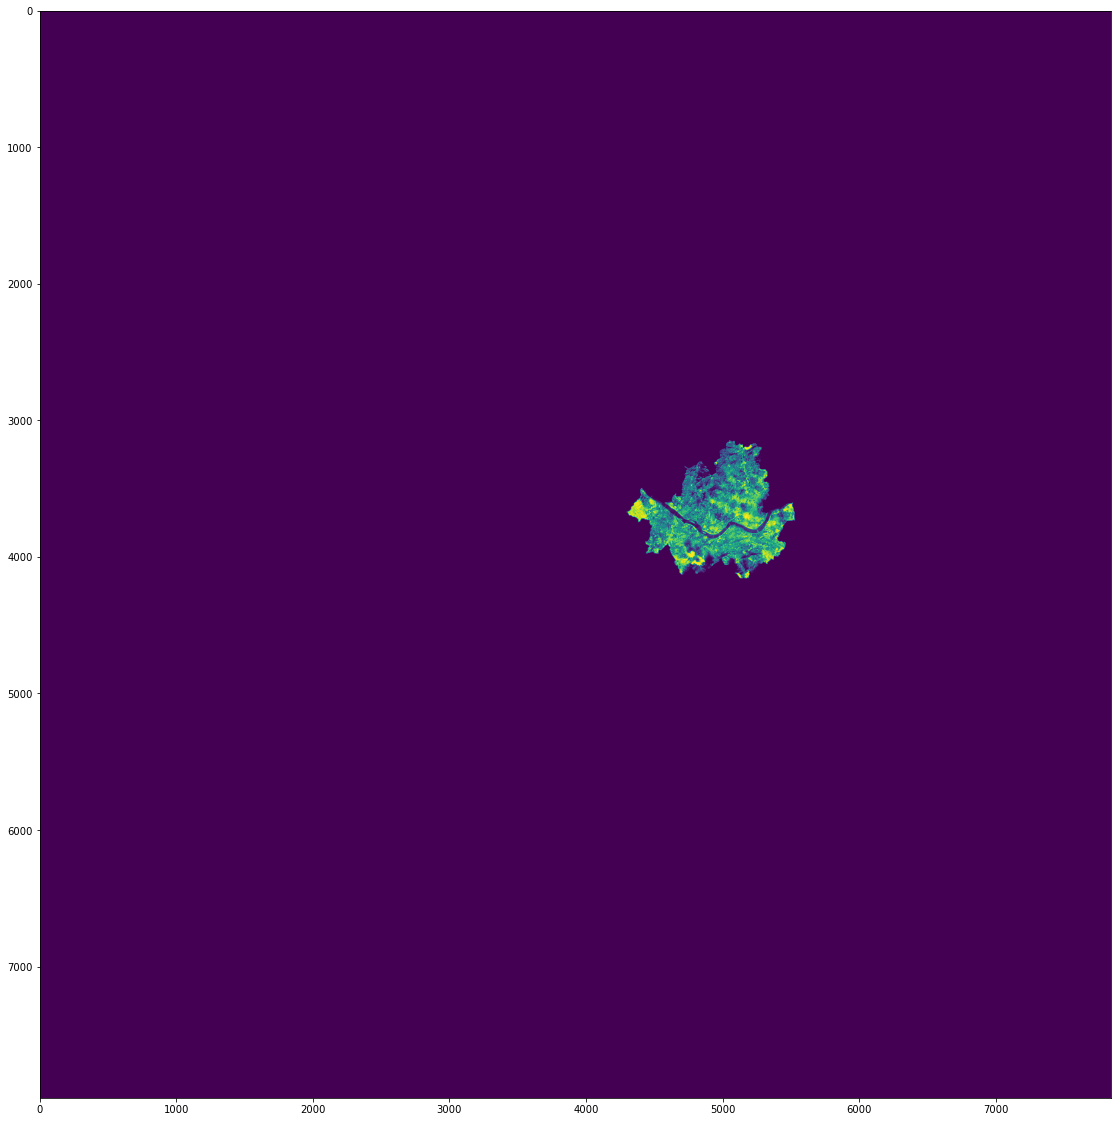

<AxesSubplot:>

In [11]:
plt.figure(figsize=(20, 20))
show(img_eq)

## Dask

### 먼저 padndas 데이터프레임 로딩 시간 확인

In [1]:
import pandas as pd
import time

In [2]:
t1 = time.time() # 처리 전 시각

df = pd.read_csv('./data/LOCAL_PEOPLE_20210107/LOCAL_PEOPLE_20210107.csv', encoding='euc-kr')

t2 = time.time()  # 처리 후 시각
elapsed_time = t2-t1  # 처리시간 계산
print(f"처리시간：{elapsed_time}")

처리시간：4.250162601470947


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 459661 entries, 0 to 459660
Data columns (total 33 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   ?"기준일ID"         459661 non-null  int64  
 1   시간대구분            459661 non-null  int64  
 2   행정동코드            459661 non-null  int64  
 3   집계구코드            459661 non-null  int64  
 4   총생활인구수           459661 non-null  float64
 5   남자0세부터9세생활인구수    459661 non-null  object 
 6   남자10세부터14세생활인구수  459661 non-null  object 
 7   남자15세부터19세생활인구수  459661 non-null  object 
 8   남자20세부터24세생활인구수  459661 non-null  object 
 9   남자25세부터29세생활인구수  459661 non-null  object 
 10  남자30세부터34세생활인구수  459661 non-null  object 
 11  남자35세부터39세생활인구수  459661 non-null  object 
 12  남자40세부터44세생활인구수  459661 non-null  object 
 13  남자45세부터49세생활인구수  459661 non-null  object 
 14  남자50세부터54세생활인구수  459661 non-null  object 
 15  남자55세부터59세생활인구수  459661 non-null  object 
 16  남자60세부터64세생활인구수  459661 non-null  obje

### Dask 데이터프레임 로딩 시간 확인

In [8]:
import  dask.dataframe as dd

In [15]:
t1 = time.time() # 처리 전 시각

ddf = dd.read_csv('./data/LOCAL_PEOPLE_20210107/LOCAL_PEOPLE_20210107.csv', encoding='euc-kr')

t2 = time.time()  # 처리 후 시각
elapsed_time2 = t2-t1  # 처리시간 계산
print(f"처리시간：{elapsed_time2}")

처리시간：0.024017333984375


### Dask 기초 문법

In [17]:
# dssk 프로그레스 바 표시
from dask.diagnostics import ProgressBar
pbar = ProgressBar()
pbar.register()

In [18]:
ddf.count().compute()  #레코드 카운트 

[########################################] | 100% Completed |  4.4s


?"기준일ID"           459661
시간대구분              459661
행정동코드              459661
집계구코드              459661
총생활인구수             459661
남자0세부터9세생활인구수      459661
남자10세부터14세생활인구수    459661
남자15세부터19세생활인구수    459661
남자20세부터24세생활인구수    459661
남자25세부터29세생활인구수    459661
남자30세부터34세생활인구수    459661
남자35세부터39세생활인구수    459661
남자40세부터44세생활인구수    459661
남자45세부터49세생활인구수    459661
남자50세부터54세생활인구수    459661
남자55세부터59세생활인구수    459661
남자60세부터64세생활인구수    459661
남자65세부터69세생활인구수    459661
남자70세이상생활인구수       459661
여자0세부터9세생활인구수      459661
여자10세부터14세생활인구수    459661
여자15세부터19세생활인구수    459661
여자20세부터24세생활인구수    459661
여자25세부터29세생활인구수    459661
여자30세부터34세생활인구수    459661
여자35세부터39세생활인구수    459661
여자40세부터44세생활인구수    459661
여자45세부터49세생활인구수    459661
여자50세부터54세생활인구수    459661
여자55세부터59세생활인구수    459661
여자60세부터64세생활인구수    459661
여자65세부터69세생활인구수    459661
여자70세이상생활인구수       459661
dtype: int64

In [19]:
ddf.columns

Index(['?"기준일ID"', '시간대구분', '행정동코드', '집계구코드', '총생활인구수', '남자0세부터9세생활인구수',
       '남자10세부터14세생활인구수', '남자15세부터19세생활인구수', '남자20세부터24세생활인구수',
       '남자25세부터29세생활인구수', '남자30세부터34세생활인구수', '남자35세부터39세생활인구수',
       '남자40세부터44세생활인구수', '남자45세부터49세생활인구수', '남자50세부터54세생활인구수',
       '남자55세부터59세생활인구수', '남자60세부터64세생활인구수', '남자65세부터69세생활인구수', '남자70세이상생활인구수',
       '여자0세부터9세생활인구수', '여자10세부터14세생활인구수', '여자15세부터19세생활인구수',
       '여자20세부터24세생활인구수', '여자25세부터29세생활인구수', '여자30세부터34세생활인구수',
       '여자35세부터39세생활인구수', '여자40세부터44세생활인구수', '여자45세부터49세생활인구수',
       '여자50세부터54세생활인구수', '여자55세부터59세생활인구수', '여자60세부터64세생활인구수',
       '여자65세부터69세생활인구수', '여자70세이상생활인구수'],
      dtype='object')

In [20]:
ddf.head()

[########################################] | 100% Completed |  2.2s


?"기준일ID"  시간대구분     행정동코드          집계구코드    총생활인구수 남자0세부터9세생활인구수  \
0  20210107      0  11110515  1101072010001  552.3424       29.4205   
1  20210107      0  11110515  1101072010002  763.8278       19.5771   
2  20210107      0  11110515  1101072010003  484.5615        25.633   
3  20210107      0  11110515  1101072010004  264.9223       12.5195   
4  20210107      0  11110515  1101072010005  538.8958       28.6444   

  남자10세부터14세생활인구수 남자15세부터19세생활인구수 남자20세부터24세생활인구수 남자25세부터29세생활인구수  ...  \
0         18.7468         22.4863          18.311         21.0077  ...   
1         12.4746         22.6336         21.2849          33.638  ...   
2         16.3334         24.7982         32.9803         11.3079  ...   
3          7.9775         11.6234          4.8236          6.8654  ...   
4         18.2523         26.3609         32.3343         14.6004  ...   

  여자25세부터29세생활인구수 여자30세부터34세생활인구수 여자35세부터39세생활인구수 여자40세부터44세생활인구수  \
0         13.4539         13.9205         18.3644         26.2724   
1         19.6423         26.5254         34.3538         22.1393   
2          6.1371         11.5148          12.644         27.6462   
3          8.4636         11.0348          8.8889         12.1462   
4          8.1484         12.7159         14.9782         29.6888   

  여자45세부터49세생활인구수 여자50세부터54세생활인구수 여자55세부터59세생활인구수 여자60세부터64세생활인구수  \
0         30.8403         24.5584         26.4258         11.3639   
1         39.3587         34.4127         23.9186         30.0748   
2         25.8107         16.7603         14.5228          4.4718   
3          9.7244          7.7986          9.8014         10.6692   
4         29.3403         19.9242         18.6091          6.1254   

  여자65세부터69세생활인구수 여자70세이상생활인구수  
0          9.5796      39.4772  
1         16.7022      82.1285  
2         14.7631      52.2126  
3          4.3216      13.0274  
4          14.651      53.4358  

[5 rows x 33 columns]

In [21]:
ddf02 = ddf[  ddf['총생활인구수'] >= 300  ].compute()

[########################################] | 100% Completed |  4.2s


In [23]:
ddf02.count()  #레코드 카운트 

?"기준일ID"           277879
시간대구분              277879
행정동코드              277879
집계구코드              277879
총생활인구수             277879
남자0세부터9세생활인구수      277879
남자10세부터14세생활인구수    277879
남자15세부터19세생활인구수    277879
남자20세부터24세생활인구수    277879
남자25세부터29세생활인구수    277879
남자30세부터34세생활인구수    277879
남자35세부터39세생활인구수    277879
남자40세부터44세생활인구수    277879
남자45세부터49세생활인구수    277879
남자50세부터54세생활인구수    277879
남자55세부터59세생활인구수    277879
남자60세부터64세생활인구수    277879
남자65세부터69세생활인구수    277879
남자70세이상생활인구수       277879
여자0세부터9세생활인구수      277879
여자10세부터14세생활인구수    277879
여자15세부터19세생활인구수    277879
여자20세부터24세생활인구수    277879
여자25세부터29세생활인구수    277879
여자30세부터34세생활인구수    277879
여자35세부터39세생활인구수    277879
여자40세부터44세생활인구수    277879
여자45세부터49세생활인구수    277879
여자50세부터54세생활인구수    277879
여자55세부터59세생활인구수    277879
여자60세부터64세생활인구수    277879
여자65세부터69세생활인구수    277879
여자70세이상생활인구수       277879
dtype: int64

In [ ]:
#ddf02.to_csv('./result/dask_test.csv') 

읽기, 쓰기, 추출(조건 선택), 집계(groupby), 항목 삭제 등은 Pandas 문법과 유사하므로   
Dask 홈페이지의 Examples 또는 Search 결과를 참조하여 사용하면 됨   

https://examples.dask.org/

### Dask 외에도 CSV 및 SHP 로딩 향상을 위한 다른 방법들도 존재함   

#### pyarrow : 대용량 csv 읽기 (Apache Arrow)  
https://yahwang.github.io/posts/83

#### geofeather : shp 로딩 향상   
https://pypi.org/project/geofeather/

## 파이썬 환경에서 공간분석/시각화가 가능한 다른 패키지

### CARTOframes   
Carto 계정(유료)이 있고 SQL이 더 익숙한 경우   

개인사용자 연간 약 300만원 -  학생 할인 참조 

https://www.sphinfo.com/python-cartoframe-1/

https://carto.com/help/getting-started/student-accounts/  


### ArcGIS API for Python - 유료

https://enterprise.arcgis.com/ko/portal/latest/use/scripting-with-the-arcgis-python-api.htm 

https://developers.arcgis.com/python/ 

오픈소스 비즈니스 모델   
Death of an Open Source Business Model  
https://joemorrison.medium.com/death-of-an-open-source-business-model-62bc227a7e9b  
https://carto.com/blog/our-thoughts-as-mapboxgl-js-2-goes-proprietary/  
  
  
https://github.com/mapbox/mapbox-gl-js  
https://github.com/maplibre/maplibre-gl-js  
  
 
https://github.com/visgl/deck.gl  
Urban Computing Foundation  https://uc.foundation/  

건물통합정보 mapbox 3D  
https://brunch.co.kr/@yeowoonbae/15  

# 수고 많으셨습니다!!!